In [1]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
f = open("cwe_mitigation_ids_temp.json")
w_mitigation = json.load(f)

f = open("capec_mitigation_temp.json")
ap_mitigation = json.load(f)

f = open("technique_mitigation_temp.json")
technique_mitigation = json.load(f)

f = open("cwe_temp.json")
cwe = json.load(f)

f = open("capec_temp.json")
capec = json.load(f)

with open("w_dict.json", "r") as f:
    w_dict = json.load(f)
with open("ap_dict.json", "r") as f:
    ap_dict = json.load(f)
with open("technique_dict.json", "r") as f:
    technique_dict = json.load(f)

In [3]:
w_mitigation_set = set()
for mitigation in w_mitigation:
    w_mitigation_set.add(mitigation["_id"])
ap_mitigation_set = set()
for mitigation in ap_mitigation:
    ap_mitigation_set.add(mitigation["_id"])
technique_mitigation_set = set()
for mitigation in technique_mitigation:
    technique_mitigation_set.add(mitigation["_id"])

In [4]:
print(len(w_mitigation_set))
print(len(ap_mitigation_set))
print(len(technique_mitigation_set))

1597
1044
43


In [5]:
f = open("cwe_cwemitigation_temp.json")
cwe_mitigation = json.load(f)

In [6]:
total = set()
count = 0
for w in w_dict:
    count += len(w_dict[w]["mitigations"])
    total.update(w_dict[w]["mitigations"])
print("Number of distinct connected CWE mitigations ", len(total))
print("Number of connected CWE mitigations ", count)
print("Number of unconnected CWE mitigations ", len(w_mitigation_set - total))

total = set()
count = 0
for ap in ap_dict:
    count += len(ap_dict[ap]["mitigations"])
    total.update(ap_dict[ap]["mitigations"])
print("Number of distinct connected AP mitigations ", len(total))
print("Number of connected AP mitigations ", count)
print("Number of unconnected AP mitigations ", len(ap_mitigation_set - total))

total = set()
count = 0
for technique in technique_dict:
    count += len(technique_dict[technique]["mitigations"])
    total.update(technique_dict[technique]["mitigations"])
print("Number of distinct connected technique mitigations ", len(total))
print("Number of connected technique mitigations ", count)
print(
    "Number of unconnected technique mitigations ",
    len(technique_mitigation_set - total),
)

Number of distinct connected CWE mitigations  1597
Number of connected CWE mitigations  1597
Number of unconnected CWE mitigations  0
Number of distinct connected AP mitigations  1044
Number of connected AP mitigations  1044
Number of unconnected AP mitigations  0
Number of distinct connected technique mitigations  43
Number of connected technique mitigations  1089
Number of unconnected technique mitigations  0


In [7]:
# it looks like technique mitigations are shared between techniques
f = open("technique_techniquemitigation_temp.json")
technique_techniquemitigation = json.load(f)

technique_techniquemitigation

[{'_key': '1538211532',
  '_id': 'TechniqueTechnique_mitigation/1538211532',
  '_from': 'technique/technique_00199',
  '_to': 'technique_mitigation/technique_mitigation_00011',
  '_rev': '_dVfOFei---'},
 {'_key': '1538211533',
  '_id': 'TechniqueTechnique_mitigation/1538211533',
  '_from': 'technique/technique_00149',
  '_to': 'technique_mitigation/technique_mitigation_00013',
  '_rev': '_dVfOFei--_'},
 {'_key': '1538211534',
  '_id': 'TechniqueTechnique_mitigation/1538211534',
  '_from': 'technique/technique_00162',
  '_to': 'technique_mitigation/technique_mitigation_00011',
  '_rev': '_dVfOFem---'},
 {'_key': '1538211535',
  '_id': 'TechniqueTechnique_mitigation/1538211535',
  '_from': 'technique/technique_00162',
  '_to': 'technique_mitigation/technique_mitigation_00015',
  '_rev': '_dVfOFem--_'},
 {'_key': '1538211536',
  '_id': 'TechniqueTechnique_mitigation/1538211536',
  '_from': 'technique/technique_00162',
  '_to': 'technique_mitigation/technique_mitigation_00017',
  '_rev': '

In [8]:
for technique in technique_dict:
    technique_dict[technique]["ap"] = []

for ap in ap_dict:
    for technique in ap_dict[ap]["techniques"]:
        technique_dict[technique]["ap"].append(ap)

In [9]:
def bidirectional_path_search(cur, visited):
    if cur in visited:
        return []
    visited.add(cur)
    mitigations = []
    if cur.startswith("capec"):
        for mitigation in ap_dict[cur]["mitigations"]:
            mitigations.append(mitigation)
        for cwe in ap_dict[cur]["cwes"]:
            res = bidirectional_path_search(cwe, visited)
            mitigations.extend(res)
        for technique in ap_dict[cur]["techniques"]:
            res = bidirectional_path_search(technique, visited)
            mitigations.extend(res)

    if cur.startswith("cwe"):
        for mitigation in w_dict[cur]["mitigations"]:
            mitigations.append(mitigation)
        for ap in w_dict[cur]["ap"]:
            res = bidirectional_path_search(ap, visited)
            mitigations.extend(res)

    if cur.startswith("technique"):
        for mitigation in technique_dict[cur]["mitigations"]:
            mitigations.append(mitigation)
        for ap in technique_dict[cur]["ap"]:
            res = bidirectional_path_search(ap, visited)
            mitigations.extend(res)

    return mitigations

In [10]:
# for each cwe, ap, and technique, bidirectionally traverse the paths in BRON to find all connected CWE, AP, and technique mitigations

clusters = []
visited = set()
for ap in ap_dict:
    if ap not in visited:
        connected_mitigations = bidirectional_path_search(ap, visited)
        if connected_mitigations:
            clusters.append(set(connected_mitigations))
for cwe in w_dict:
    if cwe not in visited:
        connected_mitigations = bidirectional_path_search(cwe, visited)
        if connected_mitigations:
            clusters.append(set(connected_mitigations))
for technique in technique_dict:
    if technique not in visited:
        connected_mitigations = bidirectional_path_search(technique, visited)
        if connected_mitigations:
            clusters.append(set(connected_mitigations))

In [11]:
clusters = set([tuple(sorted(i)) for i in clusters])

In [12]:
mitigations_found = set()
for cluster in clusters:
    for mitigation in cluster:
        mitigations_found.add(mitigation)
len(mitigations_found)

2684

In [13]:
len(clusters)

658

In [14]:
cluster_lengths = []
for cluster in clusters:
    cluster_lengths.append(len(cluster))
cluster_lengths

[2,
 3,
 1,
 4,
 4,
 4,
 2,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 3,
 1,
 3,
 6,
 2,
 3,
 6,
 2,
 2,
 5,
 3,
 1,
 3,
 4,
 3,
 2,
 2,
 2,
 1,
 1,
 2,
 5,
 2,
 2,
 1,
 2,
 4,
 3,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 4,
 1,
 1,
 1,
 7,
 4,
 1,
 2,
 2,
 1,
 1,
 3,
 7,
 1,
 3,
 3,
 3,
 1,
 41,
 2,
 2,
 1,
 4,
 3,
 11,
 5,
 2,
 1,
 3,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 9,
 2,
 4,
 2,
 4,
 1,
 1,
 3,
 1,
 4,
 2,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 4,
 2,
 2,
 2,
 3,
 6,
 4,
 2,
 4,
 1,
 1,
 3,
 2,
 3,
 3,
 1,
 2,
 3,
 1,
 5,
 1,
 3,
 2,
 17,
 3,
 2,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 4,
 3,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 3,
 2,
 2,
 7,
 3,
 4,
 4,
 1,
 1,
 12,
 2,
 3,
 1,
 1,
 2,
 3,
 4,
 2,
 1,
 4,
 4,
 2,
 2,
 5,
 2,
 4,
 1,
 4,
 5,
 1,
 2,
 1,
 2,
 2,
 5,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 6,
 2,
 1,
 1,
 2,
 1,
 8,
 1,
 2,
 1,
 4,
 4,
 2,
 3,
 1,
 3,
 5,
 3,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 4,
 1,
 5,
 2,
 2,
 6,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 148

Text(0, 0.5, 'Frequency')

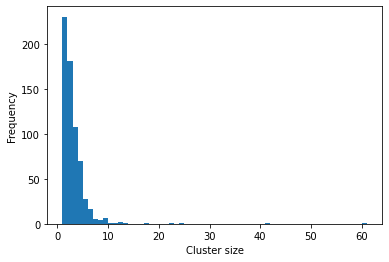

In [15]:
from matplotlib import pyplot as plt

cluster_lengths.remove(1480)
plt.hist(cluster_lengths, bins=60)
plt.xlabel("Cluster size")
plt.ylabel("Frequency")

In [16]:
np.mean(cluster_lengths)

2.6986301369863015

In [17]:
np.median(cluster_lengths)

2.0

In [18]:
mitigation_to_name = {}
for mitigation in w_mitigation:
    mitigation_to_name[mitigation["_id"]] = mitigation["metadata"]["Description"]
for mitigation in ap_mitigation:
    mitigation_to_name[mitigation["_id"]] = mitigation["metadata"]
for mitigation in technique_mitigation:
    mitigation_to_name[mitigation["_id"]] = mitigation["name"]

In [19]:
with open("ap_mitigation_descriptions.json", "r") as f:
    ap_mitigation_descriptions = list(set(json.load(f)))
with open("cwe_mitigation_descriptions.json", "r") as f:
    cwe_mitigation_descriptions = list(set(json.load(f)))
with open("tech_mitigation_names.json", "r") as f:
    tech_mitigation_names = list(set(json.load(f)))

In [20]:
def get_unique_pairs(pairwise_similarities):
    unique_pairs = []
    for i in range(len(pairwise_similarities)):
        for j in range(i + 1, len(pairwise_similarities)):
            unique_pairs.append(pairwise_similarities[i][j])

    return unique_pairs

In [21]:
# between all cwe/ap/technique mitigations

vectorizer = CountVectorizer()
vectorizer.fit(
    ap_mitigation_descriptions + cwe_mitigation_descriptions + tech_mitigation_names
)

ap_mitigation_vectors = vectorizer.transform(ap_mitigation_descriptions)
cwe_mitigation_vectors = vectorizer.transform(cwe_mitigation_descriptions)
tech_mitigation_vectors = vectorizer.transform(tech_mitigation_names)

ap_similarities_all = cosine_similarity(ap_mitigation_vectors)
among_aps = np.mean(get_unique_pairs(ap_similarities_all))

cwe_similarities_all = cosine_similarity(cwe_mitigation_vectors)
among_cwes = np.mean(get_unique_pairs(cwe_similarities_all))

tech_similarities_all = cosine_similarity(tech_mitigation_vectors)
among_techs = np.mean(get_unique_pairs(tech_similarities_all))

all_mitigation_vectors = vectorizer.transform(
    ap_mitigation_descriptions + cwe_mitigation_descriptions + tech_mitigation_names
)
among_all_mitigations = np.mean(
    get_unique_pairs(cosine_similarity(all_mitigation_vectors))
)

ap_cwe_similarities = cosine_similarity(ap_mitigation_vectors, cwe_mitigation_vectors)

ap_tech_similarities = cosine_similarity(ap_mitigation_vectors, tech_mitigation_vectors)

cwe_tech_similarities = cosine_similarity(
    cwe_mitigation_vectors, tech_mitigation_vectors
)

print("Among APs ", among_aps)
print("Among CWEs ", among_cwes)
print("Among Techs ", among_techs)
print("Between APs and CWEs ", np.mean(ap_cwe_similarities))
print("Between APs and Techniques ", np.mean(ap_tech_similarities))
print("Between CWEs and Techniques ", np.mean(cwe_tech_similarities))
print("Among all mitigations", among_all_mitigations)

Among APs  0.09346447191636709
Among CWEs  0.15633004139561232
Among Techs  0.019376344089957965
Between APs and CWEs  0.11576254620911312
Between APs and Techniques  0.014222136078380314
Between CWEs and Techniques  0.0135771463313062
Among all mitigations 0.12056129476545321


<AxesSubplot:>

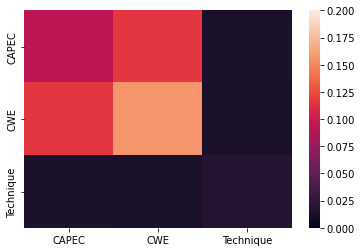

In [22]:
import seaborn as sns
import pandas as pd

similarities = {
    "CAPEC": {
        "CAPEC": among_aps,
        "CWE": np.mean(ap_cwe_similarities),
        "Technique": np.mean(ap_tech_similarities),
    },
    "CWE": {
        "CAPEC": np.mean(ap_cwe_similarities),
        "CWE": among_cwes,
        "Technique": np.mean(cwe_tech_similarities),
    },
    "Technique": {
        "CAPEC": np.mean(ap_tech_similarities),
        "CWE": np.mean(cwe_tech_similarities),
        "Technique": among_techs,
    },
}
similarities = pd.DataFrame(similarities)
sns.heatmap(similarities, vmin=0, vmax=0.2)

In [23]:
vectorizer = CountVectorizer()
vectorizer.fit(mitigation_to_name.values())

CountVectorizer()

In [24]:
heatmaps = {}
clusters = [list(x) for x in clusters]

In [25]:
# BoW similarity
similarities_list = []
comparisons = [("capec", "capec"), ("cwe", "cwe")]

for category in comparisons:
    first_clusters = []
    second_clusters = []
    for cluster in clusters:
        cluster_1 = list(filter(lambda x: x.startswith(category[0]), cluster))
        if cluster_1:
            first_clusters.append(cluster_1)
        cluster_2 = list(filter(lambda x: x.startswith(category[1]), cluster))
        if cluster_2:
            second_clusters.append(cluster_2)
    cluster_similarities = []
    for i in range(len(first_clusters)):
        cluster_1 = first_clusters[i]
        cluster_1_names = []
        for mitigation in cluster_1:
            cluster_1_names.append(mitigation_to_name[mitigation])
        cluster_1_vectors = vectorizer.transform(cluster_1_names)
        mean_similarity = 0
        for j in range(len(second_clusters)):
            cluster_2 = second_clusters[j]
            cluster_2_names = []
            for mitigation in cluster_2:
                cluster_2_names.append(mitigation_to_name[mitigation])
            cluster_2_vectors = vectorizer.transform(cluster_2_names)
            similarities = cosine_similarity(cluster_1_vectors, cluster_2_vectors)
            mean_similarity += np.mean(similarities)
        mean_similarity /= len(second_clusters)
        cluster_similarities.append((first_clusters[i], mean_similarity))
    cluster_similarities.sort(key=lambda x: x[1], reverse=True)
    clusters_similar_ranked = [x[0] for x in cluster_similarities]
    heatmap = [
        [float("nan") for j in range(len(clusters_similar_ranked))]
        for i in range(len(clusters_similar_ranked))
    ]
    heatmaps[category] = heatmap
    for i in range(len(clusters_similar_ranked)):
        cluster_1 = clusters_similar_ranked[i]
        cluster_1_names = []
        for mitigation in cluster_1:
            cluster_1_names.append(mitigation_to_name[mitigation])
        cluster_1_vectors = vectorizer.transform(cluster_1_names)
        for j in range(len(clusters_similar_ranked)):
            cluster_2 = clusters_similar_ranked[j]
            cluster_2_names = []
            for mitigation in cluster_2:
                cluster_2_names.append(mitigation_to_name[mitigation])
            cluster_2_vectors = vectorizer.transform(cluster_2_names)
            similarities = cosine_similarity(cluster_1_vectors, cluster_2_vectors)
            similarities_list.append(similarities)
            heatmap[i][j] = np.mean(similarities)

In [26]:
heatmaps.keys()

dict_keys([('capec', 'capec'), ('cwe', 'cwe')])

In [27]:
with open("heatmap_cwe.json", "w") as f:
    json.dump(heatmaps[("cwe", "cwe")], f)

In [28]:
heatmaps = {}
with open("heatmap_cwe.json", "r") as f:
    heatmaps[("cwe", "cwe")] = json.load(f)
with open("heatmap_capec.json", "r") as f:
    heatmaps[("capec", "capec")] = json.load(f)
with open("heatmap_technique.json", "r") as f:
    heatmaps[("technique", "technique")] = json.load(f)

<AxesSubplot:>

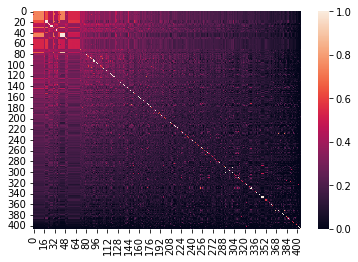

In [29]:
import seaborn as sns

category = ("cwe", "cwe")

sns.heatmap(heatmaps[category], vmin=0, vmax=1)

<AxesSubplot:>

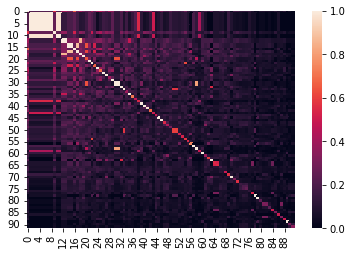

In [30]:
import seaborn as sns

category = ("capec", "capec")

sns.heatmap(heatmaps[category], vmin=0, vmax=1)

<AxesSubplot:>

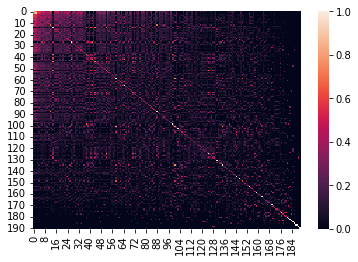

In [31]:
category = ("technique", "technique")

sns.heatmap(heatmaps[category], vmin=0, vmax=1)

In [32]:
# 406 x 406

similarities = heatmaps[("capec", "capec")]

unique_similarities = []
unique_similarities_clusters = []

for i in range(len(similarities)):
    for j in range(i + 1, len(similarities)):
        unique_similarities_clusters.append(
            [clusters_similar_ranked[i], clusters_similar_ranked[j]]
        )
        unique_similarities.append(similarities[i][j])

Text(0, 0.5, 'Frequency')

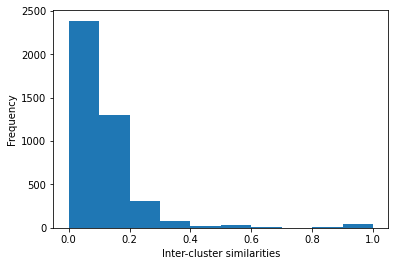

In [33]:
import matplotlib.pyplot as plt

plt.hist(unique_similarities)
plt.xlabel("Inter-cluster similarities")
plt.ylabel("Frequency")

In [34]:
max(unique_similarities)

1.0000000000000002

In [35]:
highest_similarity_clusters = []
for i in range(len(unique_similarities)):
    if unique_similarities[i] > 0.99:
        highest_similarity_clusters.append(unique_similarities_clusters[i])

In [36]:
len(highest_similarity_clusters)

32

In [37]:
highest_similarity_clusters_descriptions = []
for pair in highest_similarity_clusters:
    cluster1 = []
    cluster2 = []
    for mitigation in pair[0]:
        cluster1.append(mitigation_to_name[mitigation])
    for mitigation in pair[1]:
        cluster2.append(mitigation_to_name[mitigation])
    highest_similarity_clusters_descriptions.append([cluster1, cluster2])

In [38]:
# highest_similarity_clusters_descriptions

In [39]:
df_dict = {
    "Mitigation description": [],
    "CAPEC1 id": [],
    "CAPEC2 id": [],
    "CAPEC1 name": [],
    "CAPEC2 name": [],
}

In [40]:
for pair in highest_similarity_clusters_descriptions:
    df_dict["Mitigation description"].append(pair[0][0])

for pair in highest_similarity_clusters:
    cluster1 = []
    cluster2 = []
    for mitigation in pair[0]:
        for cwe in ap_dict:
            if mitigation in ap_dict[cwe]["mitigations"]:
                df_dict["CAPEC1 name"].append(ap_dict[cwe]["name"])
                break
    for mitigation in pair[1]:
        for cwe in ap_dict:
            if mitigation in ap_dict[cwe]["mitigations"]:
                df_dict["CAPEC2 name"].append(ap_dict[cwe]["name"])
                break

f = open("cwe_temp.json")
cwe = json.load(f)
f = open("capec_temp.json")
capec = json.load(f)

for pair in highest_similarity_clusters:
    cluster1 = []
    cluster2 = []
    for mitigation in pair[0]:
        for cwe_id in ap_dict:
            if mitigation in ap_dict[cwe_id]["mitigations"]:
                for w in capec:
                    if cwe_id == w["_id"]:
                        df_dict["CAPEC1 id"].append(w["original_id"])
                        break
                break
    for mitigation in pair[1]:
        for cwe_id in ap_dict:
            if mitigation in ap_dict[cwe_id]["mitigations"]:
                for w in capec:
                    if cwe_id == w["_id"]:
                        df_dict["CAPEC2 id"].append(w["original_id"])
                        break
                break

In [41]:
df_dict

{'Mitigation description': ['\n                  Assume all input is malicious. Use an "accept known good" input validation strategy, i.e., use a list of acceptable inputs that strictly conform to specifications. Reject any input that does not strictly conform to specifications, or transform it into something that does.\n                  When performing input validation, consider all potentially relevant properties, including length, type of input, the full range of acceptable values, missing or extra inputs, syntax, consistency across related fields, and conformance to business rules. As an example of business rule logic, "boat" may be syntactically valid because it only contains alphanumeric characters, but it is not valid if the input is only expected to contain colors such as "red" or "blue."\n                  Do not rely exclusively on looking for malicious or malformed inputs.  This is likely to miss at least one undesirable input, especially if the code\'s environment changes.

In [42]:
df = pd.DataFrame(df_dict["Mitigation description"])

In [43]:
df.to_csv("identical capec mitigations.csv", index=False)

In [44]:
cwes = []
for pair in highest_similarity_clusters:
    cluster1 = []
    cluster2 = []
    for mitigation in pair[0]:
        for cwe in ap_dict:
            if mitigation in ap_dict[cwe]["mitigations"]:
                cluster1.append(ap_dict[cwe]["techniques"])
                break
    for mitigation in pair[1]:
        for cwe in ap_dict:
            if mitigation in ap_dict[cwe]["mitigations"]:
                cluster2.append(ap_dict[cwe]["techniques"])
                break
    cwes.append([cluster1, cluster2])

In [45]:
most_similar_cluster_lengths = []
for cluster in clusters_similar_ranked[:80]:
    most_similar_cluster_lengths.append(len(cluster))

In [46]:
np.median(most_similar_cluster_lengths)

2.0

Text(0, 0.5, 'Frequency')

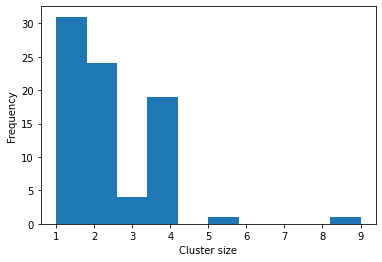

In [47]:
from matplotlib import pyplot as plt

plt.hist(most_similar_cluster_lengths)
plt.xlabel("Cluster size")
plt.ylabel("Frequency")

In [48]:
# pairwise CWE mitigation similarities within each of the clusters
clusters = [list(x) for x in clusters]
clusters.sort(key=len)

mean_std = {"mean": [], "standard deviation": []}
comparisons = [("cwe", "cwe")]

pairwise_similarities = []

for category in comparisons:
    for cluster in clusters:
        if len(cluster) > 1:
            filtered_cluster = list(filter(lambda x: x.startswith("cwe"), cluster))
            cluster_names = []
            for mitigation in cluster:
                cluster_names.append(mitigation_to_name[mitigation])
            cluster_vectors = vectorizer.transform(cluster_names)
            similarities = cosine_similarity(cluster_vectors)
            unique_similarities = get_unique_pairs(similarities)
            pairwise_similarities.extend(unique_similarities)
            mean_std["mean"].append(np.mean(similarities))
            mean_std["standard deviation"].append(np.std(similarities))

pairwise_similarities.sort(reverse=True)

In [49]:
count = 0
for similarity in pairwise_similarities:
    if similarity >= 1:
        count += 1

print(count)
print(len(pairwise_similarities))

847
1099938


In [50]:
# pairwise CWE mitigation similarities within each of the largest clusters
clusters = [list(x) for x in clusters]
clusters.sort(key=len)

comparisons = [("cwe", "cwe")]

pairwise_similarities = []

filtered_clusters = []
for cluster in clusters:
    filtered_cluster = list(filter(lambda x: x.startswith("cwe"), cluster))
    if filtered_cluster:
        filtered_clusters.append(filtered_cluster)

for i in range(len(filtered_clusters)):
    cluster_1 = filtered_clusters[i]
    cluster_1_names = []
    for mitigation in cluster_1:
        cluster_1_names.append(mitigation_to_name[mitigation])
    cluster_1_vectors = vectorizer.transform(cluster_1_names)
    for j in range(i + 1, len(filtered_clusters)):
        cluster_2 = filtered_clusters[j]
        cluster_2_names = []
        for mitigation in cluster_2:
            cluster_2_names.append(mitigation_to_name[mitigation])
        cluster_2_vectors = vectorizer.transform(cluster_2_names)
        similarities = cosine_similarity(cluster_1_vectors, cluster_2_vectors)
        pairwise_similarities.extend(similarities.flatten())


pairwise_similarities.sort(reverse=True)

In [51]:
count = 0
for similarity in pairwise_similarities:
    if similarity == 1:
        count += 1

print(count)
print(len(pairwise_similarities))

156
1046253


In [52]:
mean_std_df = pd.DataFrame(mean_std)
mean_std_df.to_csv("mean_std_largest_clusters_similarity.csv", index=False)

In [53]:
# mitigation types in the 1480 mitigations cluster
max_len = 0
max_cluster = None
for cluster in clusters:
    if len(cluster) > max_len:
        max_len = len(cluster)
        max_cluster = cluster

cwe_count = 0
ap_count = 0
tech_count = 0
for mitigation in max_cluster:
    if mitigation.startswith("cwe"):
        cwe_count += 1
    if mitigation.startswith("capec"):
        ap_count += 1
    if mitigation.startswith("technique"):
        tech_count += 1

In [54]:
print("Cwe mitigations ", cwe_count)
print("Ap mitigations ", ap_count)
print("Technique mitigations ", tech_count)

Cwe mitigations  673
Ap mitigations  776
Technique mitigations  31
